## Importamos as bibliotecas

In [5]:
import numpy as np
import cv2
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint


## Baixamos o dataset

In [6]:
# Configuração para evitar logs desnecessários
tf.get_logger().setLevel('ERROR')

# Defina o caminho da pasta principal onde estão os dados
pasta = "/kaggle/input/the-algae-cell-images/algae_data_11"

# Verificar se a pasta foi extraída corretamente
if not os.path.exists(pasta):
    print("Erro: O dataset não foi extraído corretamente.")
else:
    print("Dataset extraído com sucesso!")

# Inicialize os arrays para armazenar os dados e os rótulos
dataset = []
label = []
SIZE = 224

# Obtenha a lista de categorias (subpastas), excluindo a subpasta "nontoxic"
categorias = [d for d in os.listdir(pasta) if os.path.isdir(os.path.join(pasta, d)) and d != "nontoxic"]

# Iterar sobre cada categoria
for label_idx, categoria in enumerate(categorias):
    subpasta = os.path.join(pasta, categoria)
    imagens = [img for img in os.listdir(subpasta) if img.endswith('.jpg')]

    for image_name in imagens:
        img_path = os.path.join(subpasta, image_name)
        img = cv2.imread(img_path)

        if img is not None:
            img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            img = img.resize((SIZE, SIZE))
            dataset.append(np.array(img))
            label.append(label_idx)

print(f"Dataset criado com {len(dataset)} imagens e {len(label)} rótulos.")


Dataset extraído com sucesso!
Dataset criado com 1650 imagens e 1650 rótulos.


## Processamos os dados

In [7]:
# Pré-processamento dos dados
def preprocess_data(X, Y):
    X = X.astype('float32')
    X_p = preprocess_input(X)
    Y_p = to_categorical(Y, len(categorias))
    return X_p, Y_p

# Conversão para numpy arrays
dataset = np.array(dataset)
label = np.array(label)

# Divisão dos dados
X_train, X_temp, Y_train, Y_temp = train_test_split(dataset, label, 
                                                    test_size=0.4, 
                                                    random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, 
                                                Y_temp, 
                                                test_size=0.5, 
                                                random_state=42)

X_train_p, Y_train_p = preprocess_data(X_train, Y_train)
X_val_p, Y_val_p = preprocess_data(X_val, Y_val)
X_test_p, Y_test_p = preprocess_data(X_test, Y_test)


## Definimos o modelo

In [ ]:
# Construção do modelo
base_model = VGG16(include_top=False, 
                   weights='imagenet', 
                   pooling='avg', 
                   input_shape=(224, 224, 3))

# Dicionário para armazenar os históricos de treinamento
history_dict = {}

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(len(categorias), activation='softmax')
])

# Callbacks
def decay(epoch):
    """Função para ajustar a taxa de aprendizado."""
    return 0.001 / (1 + 1 * 20)

# Lista de callbacks
callbacks = [
    LearningRateScheduler(decay, verbose=1),
    ModelCheckpoint('/kaggle/working/phytoplankton.keras', 
                    save_best_only=True, 
                    monitor='val_loss', 
                    mode='min'),
     EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

# Compilação do modelo
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


## Treinamos o modelo

In [ ]:
# Treinamento
for batch_size in [16, 32, 64]:
    history = model.fit(X_train_p, 
                        Y_train_p, 
                        batch_size=batch_size, 
                        validation_data=(X_val_p, Y_val_p), 
                        epochs=100, 
                        shuffle=True, 
                        callbacks=callbacks,
                        verbose=1)

# Armazena o histórico de treinamento no dicionário
history_dict[batch_size] = history

## Visualizamos o comportamento do modelo

In [17]:
import matplotlib.pyplot as plt

# Encontra o batch_size com a melhor acurácia de validação
best_batch_size = max(history_dict, key=lambda k: max(history_dict[k].history['val_accuracy']))

# Plota os gráficos apenas para o melhor batch_size
best_history = history_dict[best_batch_size]

plt.figure(figsize=(14, 5))

# Gráfico de acurácia
plt.subplot(1, 2, 1)
plt.plot(best_history.history['accuracy'], label='Train Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Acurácia (batch_size={best_batch_size})')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Gráfico de perda
plt.subplot(1, 2, 2)
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title(f'Perda (batch_size={best_batch_size})')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'history_dict' is not defined

## Avaliamos o melhor modelo com os dados de teste

In [10]:
from tensorflow.keras.models import load_model

# Carregue o modelo salvo
model = load_model('phytoplankton.keras')

# Avalia o modelo no conjunto de teste
score = model.evaluate(X_test_p, Y_test_p)
#print(f"Resultados para batch_size = {batch_size}:")
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.9094 - loss: 0.4647
Test loss: 0.4251765310764313
Test accuracy: 0.9151515364646912


## Analisamos as métricas de desempenho

In [12]:
# Gere as previsões do modelo
y_pred = model.predict(X_test_p)

# Converta as previsões de probabilidades para classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Converta os rótulos verdadeiros de one-hot encoding para classes
y_true = np.argmax(Y_test_p, axis=1)

# Gere o relatório de classificação
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classes, target_names=categorias))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
               precision    recall  f1-score   support

    Noctiluca       0.92      1.00      0.96        24
     Anabaena       0.89      0.81      0.85        31
 Prorocentrum       1.00      0.95      0.97        37
      Karenia       1.00      1.00      1.00        31
       Nostoc       0.81      0.77      0.79        22
    Nodularia       0.71      0.77      0.74        26
 Oscillatoria       0.89      0.91      0.90        34
Aphanizomenon       0.88      0.88      0.88        34
  Microcystis       0.97      1.00      0.98        32
  Gymnodinium       1.00      0.93      0.97        30
  Skeletonema       0.94      1.00      0.97        29

     accuracy                           0.92       330
    macro avg       0.91      0.91      0.91       330
 weighted avg       0.92      0.92      0.92       330



In [15]:
from sklearn.metrics import classification_report

# Avalie no conjunto de treinamento
y_train_pred = model.predict(X_train_p)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true = np.argmax(Y_train_p, axis=1)
print("Relatório de Classificação (Treinamento):")
print(classification_report(y_train_true, y_train_pred_classes, target_names=categorias))

# Avalie no conjunto de validação
y_val_pred = model.predict(X_val_p)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(Y_val_p, axis=1)
print("Relatório de Classificação (Validação):")
print(classification_report(y_val_true, y_val_pred_classes, target_names=categorias))

31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 528ms/step
Relatório de Classificação (Treinamento):
               precision    recall  f1-score   support

    Noctiluca       1.00      1.00      1.00        99
     Anabaena       1.00      1.00      1.00        86
 Prorocentrum       1.00      1.00      1.00        79
      Karenia       0.99      1.00      0.99        84
       Nostoc       0.98      0.99      0.98        93
    Nodularia       0.99      0.98      0.98        97
 Oscillatoria       1.00      0.99      0.99        94
Aphanizomenon       0.99      1.00      0.99        90
  Microcystis       1.00      1.00      1.00        85
  Gymnodinium       1.00      0.99      0.99        92
  Skeletonema       1.00      1.00      1.00        91

     accuracy                           0.99       990
    macro avg       1.00      1.00      1.00       990
 weighted avg       0.99      0.99      0.99       990

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
Relatório de Classificação (Validação):
       

## Visualizamos a matriz de confusão

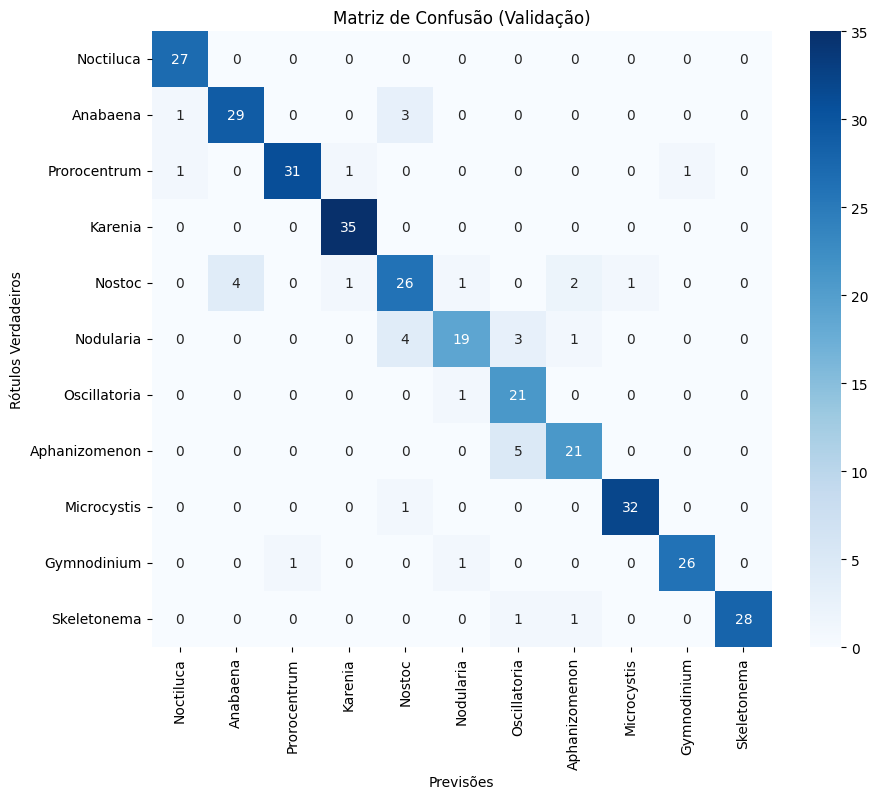

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Matriz de confusão para o conjunto de validação
cm = confusion_matrix(y_val_true, y_val_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categorias, yticklabels=categorias)
plt.title('Matriz de Confusão (Validação)')
plt.xlabel('Previsões')
plt.ylabel('Rótulos Verdadeiros')
plt.show()

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("guilfer/model-saved")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/model-saved


In [8]:
from tensorflow.keras.models import load_model
import shutil

# Caminho do modelo no Kaggle (após o upload)
model_path = '/kaggle/input/model-saved/phytoplankton.keras'

# Copie o modelo para /kaggle/working/ (opcional)
destination_path = '/kaggle/working/phytoplankton.keras'
shutil.copy(model_path, destination_path)

# Carregue o modelo
model = load_model(destination_path)

# Verifique se o modelo foi carregado corretamente
model.summary()

# Use o modelo para inferência ou avaliação
# Exemplo: Avalie o modelo no conjunto de teste
score = model.evaluate(X_test_p, Y_test_p)
print(f"Acurácia no teste: {score[1]:.4f}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 512)                 │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 11)                  │           2,827 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,334,499 (172.94 MB)

 Trainable params: 15,111,499 (57.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 30,223,000 (115.29 MB)

11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 709ms/step - accuracy: 0.9094 - loss: 0.4647
Acurácia no teste: 0.9152
